#Необходимые вещи из прошлых ноутбуков

In [ ]:
import numpy as np  

import seaborn as sns

In [ ]:
np.random.seed(1)

Сгенерируем выборку:

In [ ]:
def linear_func(x):
    target_k = 5
    target_b = -2
    return target_k * x + target_b

In [ ]:
xes = np.linspace(0, 1, 11)

print(xes)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [ ]:
target_ys = np.array([linear_func(x) for x in xes])
print(target_ys)

[-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3. ]


In [ ]:
noise = np.random.normal(0, 0.1, 11)
noisy_target_ys = target_ys + noise

print(noisy_target_ys)

[-1.83756546 -1.56117564 -1.05281718 -0.60729686  0.08654076  0.26984613
  1.17448118  1.42387931  2.03190391  2.47506296  3.14621079]


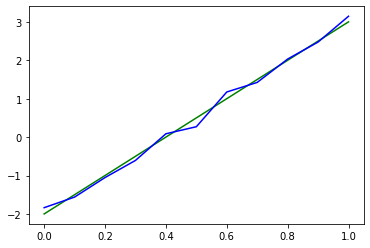

In [ ]:
sns.lineplot(x = xes, y = target_ys, color = "g")
sns.lineplot(x = xes, y = noisy_target_ys, color = "b")


#Начало нового материала

Переходим к более сложным конструкциям — несколько входных параметров, несколько нейронов.

Создадим линейный слой — основной элемент нашей сети.

In [ ]:
class SimpleLinearLayer:
    def __init__(self, input_size, output_size):
        
        self.input_size = input_size
        self.output_size = output_size
        
        self.W = np.random.random_sample((output_size, input_size)) * 2 - 1
        self.b = np.random.random_sample((output_size,)) * 2 - 1
            
        self.grad_W = np.zeros((output_size, input_size))
        self.grad_b = np.zeros((output_size,))
        
    def forward(self, x):
        h = self.W @ x + self.b 
        return h
    
    def backward(self, delta_next, w_next):
        return w_next.T @ delta_next

    def backward_as_last_layer(self, loss_der):
        return loss_der
    
    def clear_grad(self):
        self.grad_W = np.zeros((self.output_size, self.input_size))
        self.grad_b = np.zeros((self.output_size,))

In [ ]:
import tqdm


class SimpleNN:
    def __init__(self, structure, loss, loss_derivative):
        self.structure = structure
        self.layers = []
        self.loss = loss
        self.loss_derivative = loss_derivative
        for i in range(1, len(structure)):
            self.layers.append(SimpleLinearLayer(structure[i-1], structure[i]))
        
    def apply(self, x):
        h_array = [x]
        for layer in self.layers:
            h = layer.forward(h_array[-1])
            h_array.append(h)
        return h_array[-1]
    
    def forward(self, x):
        h_array = [x]
        for layer in self.layers:
            h = layer.forward(h_array[-1])
            h_array.append(h)      
        return h_array
    
    def clear_grad_values(self):
        for layer in self.layers:
            layer.clear_grad()
    
    def train(self, X, y, iter_num = 500, alpha = 0.1):
        cnt = 0
        m = len(y)
        avg_cost_func = []     
        for _ in tqdm.tqdm(range(iter_num)):    
            avg_cost = 0
            self.clear_grad_values()
            for i in range(len(y)):             
                # one sample per time
                # forward
                h = self.forward(X[i, :])

                # backward pass
                grads = {}
                for layer_num, layer in reversed(list(enumerate(self.layers))):
                    if layer_num == len(self.layers) - 1:
                        loss_deriv = self.loss_derivative(h[-1], y[i,:])
                        avg_cost += self.loss(h[-1], y[i,:])
                        grads[layer_num] = layer.backward_as_last_layer(loss_deriv)
                    else:
                        grads[layer_num] = layer.backward(grads[layer_num+1], self.layers[layer_num+1].W)
                    layer.grad_W += grads[layer_num][:,np.newaxis] @ np.transpose(h[layer_num][:,np.newaxis])
                    layer.grad_b += grads[layer_num]
                        
            # update weights
            for layer in self.layers:
                layer.W -= alpha * (layer.grad_W / m)
                layer.b -= alpha * (layer.grad_b / m)
                
            # complete the average cost calculation
            avg_cost = avg_cost / m
            avg_cost_func.append(avg_cost)
            
        return avg_cost_func

Зададим метрики:

In [ ]:
def MSE_loss(x, y):
    return ((x-y) ** 2).mean()

def MSE_loss_derivative(x, y):
    return 2 * (x - y)

Реализуем обучение нашей модели:

 42%|████▏     | 208/500 [00:00<00:00, 2071.78it/s]

[0.92469357]


100%|██████████| 500/500 [00:00<00:00, 2038.74it/s]


0.014721151034674225
[8.06831886]


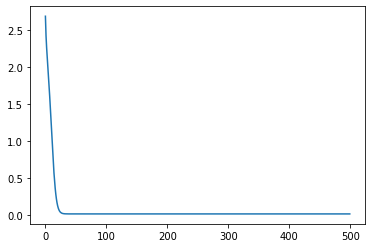

In [ ]:
N = SimpleNN([1,2,1], MSE_loss, MSE_loss_derivative)

print(N.apply([1]))

avg_cost_func = N.train(xes.reshape(-1, 1), noisy_target_ys.reshape(-1, 1))

print(avg_cost_func[-1])

sns.lineplot(data=avg_cost_func)


prediction = N.apply([2])
print(prediction)